# Receiver Function


[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/receiver_function/receiver_function.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

In this notebook, we run inversion on a toy model with optimisation and parallel sampling.

## 0. Import modules

In [85]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi geo-espresso

In [86]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import arviz
import emcee
import multiprocessing

import cofi
import espresso

In [87]:
# randomness is used to initialise emcee walkers starting points
np.random.seed(42)

In [88]:
# display theory on receiver function
from IPython.display import display, Markdown

with open("../../theory/geo_receiver_function.md", "r") as f:
    content = f.read()

display(Markdown(content))

Receiver functions are a class of seismic data used to study discontinuities (layering) in the Earth's crust. At each discontinuity, P-to-S conversions occur, introducing complexity in the waveform. By deconvolving horizontal- and vertical-channel waveforms from earthquakes at teleseismic distances, we can isolate information about these conversions, and hence learn about the crustal structure. This deconvolved signal is the receiver function, and has a highly non-linear dependence on the local crustal properties.

We refer you to the paper below for description of the algorithms and the forward kernel we use:

*Genetic algorithm inversion for receiver functions with application to crust and uppermost mantle structure beneath Eastern Australia*,
Shibutani, T., Kennett, B. and Sambridge, M., Geophys. Res. Lett., 23 , No. 4, 1829-1832, 1996.

In order to better understand the complexity and non-linear nature of seismic receiver function inversion, we have included a few illustrative animations. These animations highlight the substantial influence of velocities and, more prominently, interface depths on the resulting receiver functions.

![depth_layer3_anim4.gif](https://github.com/inlab-geo/cofi-examples/blob/main/theory/illustrations/depth_layer3_anim4.gif?raw=true)

![vel_layer3_anim4_400f.gif](https://github.com/inlab-geo/cofi-examples/blob/main/theory/illustrations/vel_layer3_anim4_400f.gif?raw=true)

This is a non-linear problem which can be highly sensitive to the starting model. 

![3Dsurf_x40y10_v55_l270_35](https://github.com/inlab-geo/cofi-examples/blob/main/theory/illustrations/3Dsurf_x40y10_v55_l270_35.png?raw=true)


We are going to use the receiver function kernel wrapped in 
[`espresso`](https://geo-espresso.readthedocs.io/en/latest/user_guide/contrib/generated/_receiver_function/index.html),
with calls to Fortran routines developed by Takuo Shibutani in the backend.

In [89]:
my_receiver_function = espresso.ReceiverFunctionInversionShibutani(example_number=4)

Consider a model setup of `n` layers described with 3 parameters for each layer. `model` is a NumPy array of dimension `[nlayers,3]`. The values in `model[:,0]` give the depths of discontinuities in the model, while `model[:,1]` contains the S-wave speed above the interface. `model[:,2]` is the ratio of S-wave speed to P-wave speed. The maximum depth of discontinuity that can be considered is 60km.

In this example, we fix the ratio of S-wave speed to P-wave speed, and treat the interface depths and velocities of 3 layers as unknowns.

Here we set a starting model that is reasonably close to the true model, so that the optimisation converges.

In [90]:
null_model = my_receiver_function.starting_model 

print(f"Number of model parameters in this example: {null_model.size}")
my_receiver_function._model_setup(null_model)

Number of model parameters in this example: 6


array([[ 9. ,  3.2,  1.7],
       [20. ,  4. ,  1.7],
       [50. ,  4.3,  1.7]])

Let's plot the starting Earth model.

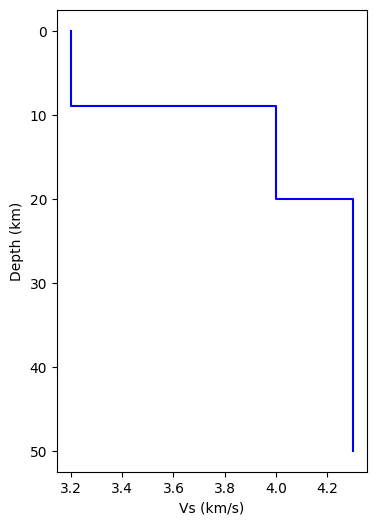

In [91]:
my_receiver_function.plot_model(null_model);

Now we calculate the receiver function and plot it

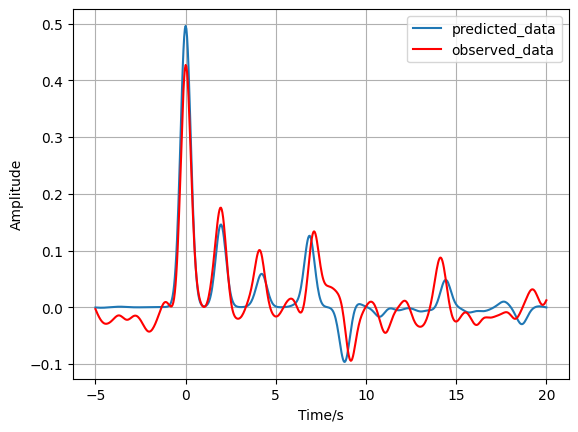

In [92]:
predicted_data = my_receiver_function.forward(null_model)
observed_data = my_receiver_function.data 
my_receiver_function.plot_data(
    data1=predicted_data, 
    data2=observed_data, 
    label="predicted_data", 
    label2="observed_data", 
)
plt.legend();

## 1. Solve with an optimiser

### 1.1 Define BaseProblem

In [93]:
my_problem = cofi.BaseProblem()

In preparation for optimisation:

In [94]:
def my_misfit(model, include_uncertainty=False):
    predicted_data = my_receiver_function.forward(model)
    misfit_val = my_receiver_function.misfit(predicted_data, observed_data)
    if math.isnan(misfit_val):
        return float("inf")
    return misfit_val

my_problem.set_objective(my_misfit)
my_problem.set_initial_model(null_model)

my_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: (6,)
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'initial_model', 'model_shape']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
-- none --
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'blobs_dtype', 'bounds', 'constraints']


### 1.2 Define InversionOptions

In [95]:
my_options_optimiser = cofi.InversionOptions()
my_options_optimiser.set_tool("scipy.optimize.minimize")
my_options_optimiser.set_params(method="Nelder-Mead")   # Nelder-Mead or COBYLA

### 1.3 Define Inversion and run

In [96]:
inv_optimiser = cofi.Inversion(my_problem, my_options_optimiser)
my_result_optimiser = inv_optimiser.run()
my_result_optimiser.summary()

Summary for inversion result
SUCCESS
----------------------------
fun: 7602.1583100559965
nit: 422
nfev: 763
status: 0
message: Optimization terminated successfully.
final_simplex: (array([[11.64646816,  2.95864063, 16.94213552,  3.85610333, 46.96829675,
         4.4324075 ],
       [11.64646815,  2.95864063, 16.94213555,  3.85610333, 46.96829677,
         4.43240749],
       [11.64646821,  2.95864062, 16.94213542,  3.85610333, 46.96829677,
         4.43240749],
       [11.64646832,  2.95864061, 16.94213521,  3.8561033 , 46.96829669,
         4.43240747],
       [11.64646828,  2.95864062, 16.94213528,  3.8561033 , 46.96829672,
         4.43240747],
       [11.6464683 ,  2.95864062, 16.94213527,  3.8561033 , 46.9682967 ,
         4.43240747],
       [11.6464681 ,  2.95864063, 16.94213558,  3.85610334, 46.9682968 ,
         4.4324075 ]]), array([7602.15831006, 7602.15831006, 7602.15831006, 7602.15831006,
       7602.15831006, 7602.15831006, 7602.15831006]))
model: [11.64646816  2.9586406

In [97]:
print("Inversion result:    ", my_result_optimiser.model)
print("Reference good model:", my_receiver_function.good_model)

Inversion result:     [11.64646816  2.95864063 16.94213552  3.85610333 46.96829675  4.4324075 ]
Reference good model: [ 8.   3.  20.   3.9 45.   4.4]


### 1.4 Plotting

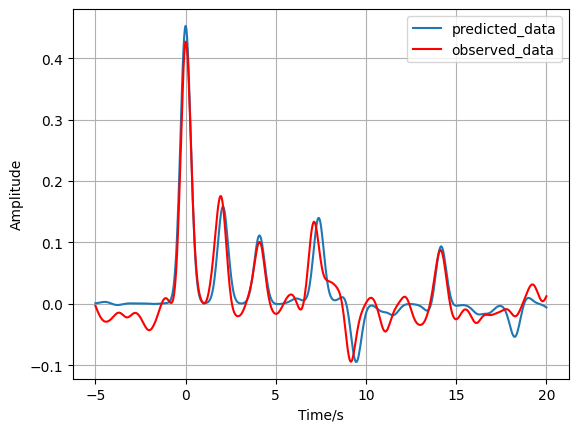

In [98]:
predicted_data = my_receiver_function.forward(my_result_optimiser.model)
my_receiver_function.plot_data(
    data1=predicted_data, 
    data2=observed_data, 
    label="predicted_data", 
    label2="observed_data", 
)
plt.legend();

## 2. Solve with a sampler

### 2.1 Enrich BaseProblem

In preparation for sampling:

In [99]:
def my_log_likelihood(model):
    data1 = my_receiver_function.data
    data2 = my_receiver_function.forward(model)
    log_likelihood = my_receiver_function.log_likelihood(data1, data2) / 20 # temper the likelihood
    return log_likelihood

def my_log_prior(model):
    log_prior = my_receiver_function.log_prior(model)
    return log_prior

ndim = my_receiver_function.model_size

my_problem.set_model_shape(ndim)
my_problem.set_log_likelihood(my_log_likelihood)
my_problem.set_log_prior(my_log_prior)

my_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: 6
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'log_likelihood', 'log_prior', 'initial_model', 'model_shape', 'blobs_dtype']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['log_posterior', 'log_posterior_with_blobs']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'bounds', 'constraints']


In [100]:
nwalkers = 12
nsteps = 25000
walkers_start = my_result_optimiser.model + 1e-1 * np.random.randn(nwalkers, ndim)

We can run `emcee` in parallel. Some additional preparation:

### 2.2 Define InversionOptions, Inversion and run

In [101]:
import warnings
warnings.filterwarnings("ignore")

my_options_sampler = cofi.InversionOptions()
my_options_sampler.set_tool("emcee")
my_options_sampler.set_params(
    nwalkers=nwalkers,
    nsteps=nsteps,
    initial_state=walkers_start,
    progress=True,
)
inv_sampler = cofi.Inversion(my_problem, my_options_sampler)
inv_result_sampler = inv_sampler.run()

100%|██████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:46<00:00, 540.75it/s]


In [102]:
inv_result_sampler.summary()

Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### 2.3 Plotting

In [103]:
var_names = [
    "depth1 (km)", 
    "velocity1 (km/s)", 
    "depth2 (km)", 
    "velocity2 (km/s)", 
    "depth3 (km)", 
    "velocity3 (km/s)", 
]
az_inf_data = inv_result_sampler.to_arviz(var_names=var_names)
az_inf_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior

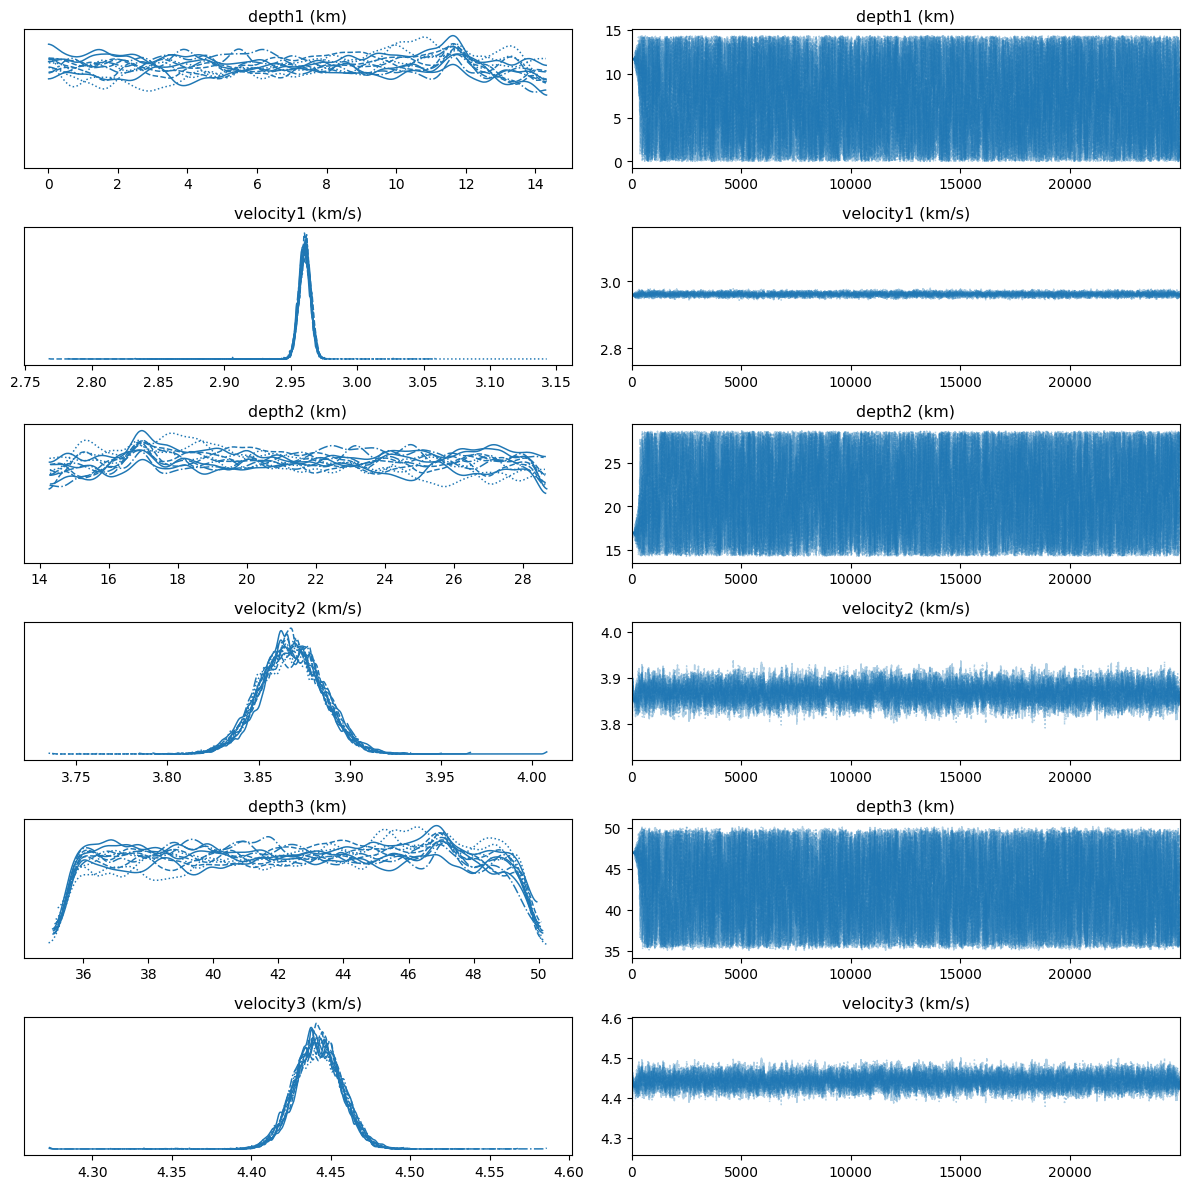

In [104]:
arviz.plot_trace(az_inf_data, var_names=var_names);
plt.tight_layout();

The walkers start in small distributions around some chosen values and then they quickly wander and start exploring the full posterior distribution. In fact, after a relatively small number of steps, the samples seem pretty well “burnt-in”. That is a hard statement to make quantitatively, but we can look at an estimate of the integrated autocorrelation time (see Emcee's package the -[*Autocorrelation analysis & convergence tutorial*](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/) for more details):

In [105]:
tau = inv_result_sampler.sampler.get_autocorr_time()
print(f"autocorrelation time: {tau}")

autocorrelation time: [103.07036006  85.02358273 103.0377668   88.56539318 103.18924139
  89.17069585]


Let’s discard the initial 300 steps and make a corner plot:

Reference good model: [ 8.   3.  20.   3.9 45.   4.4]


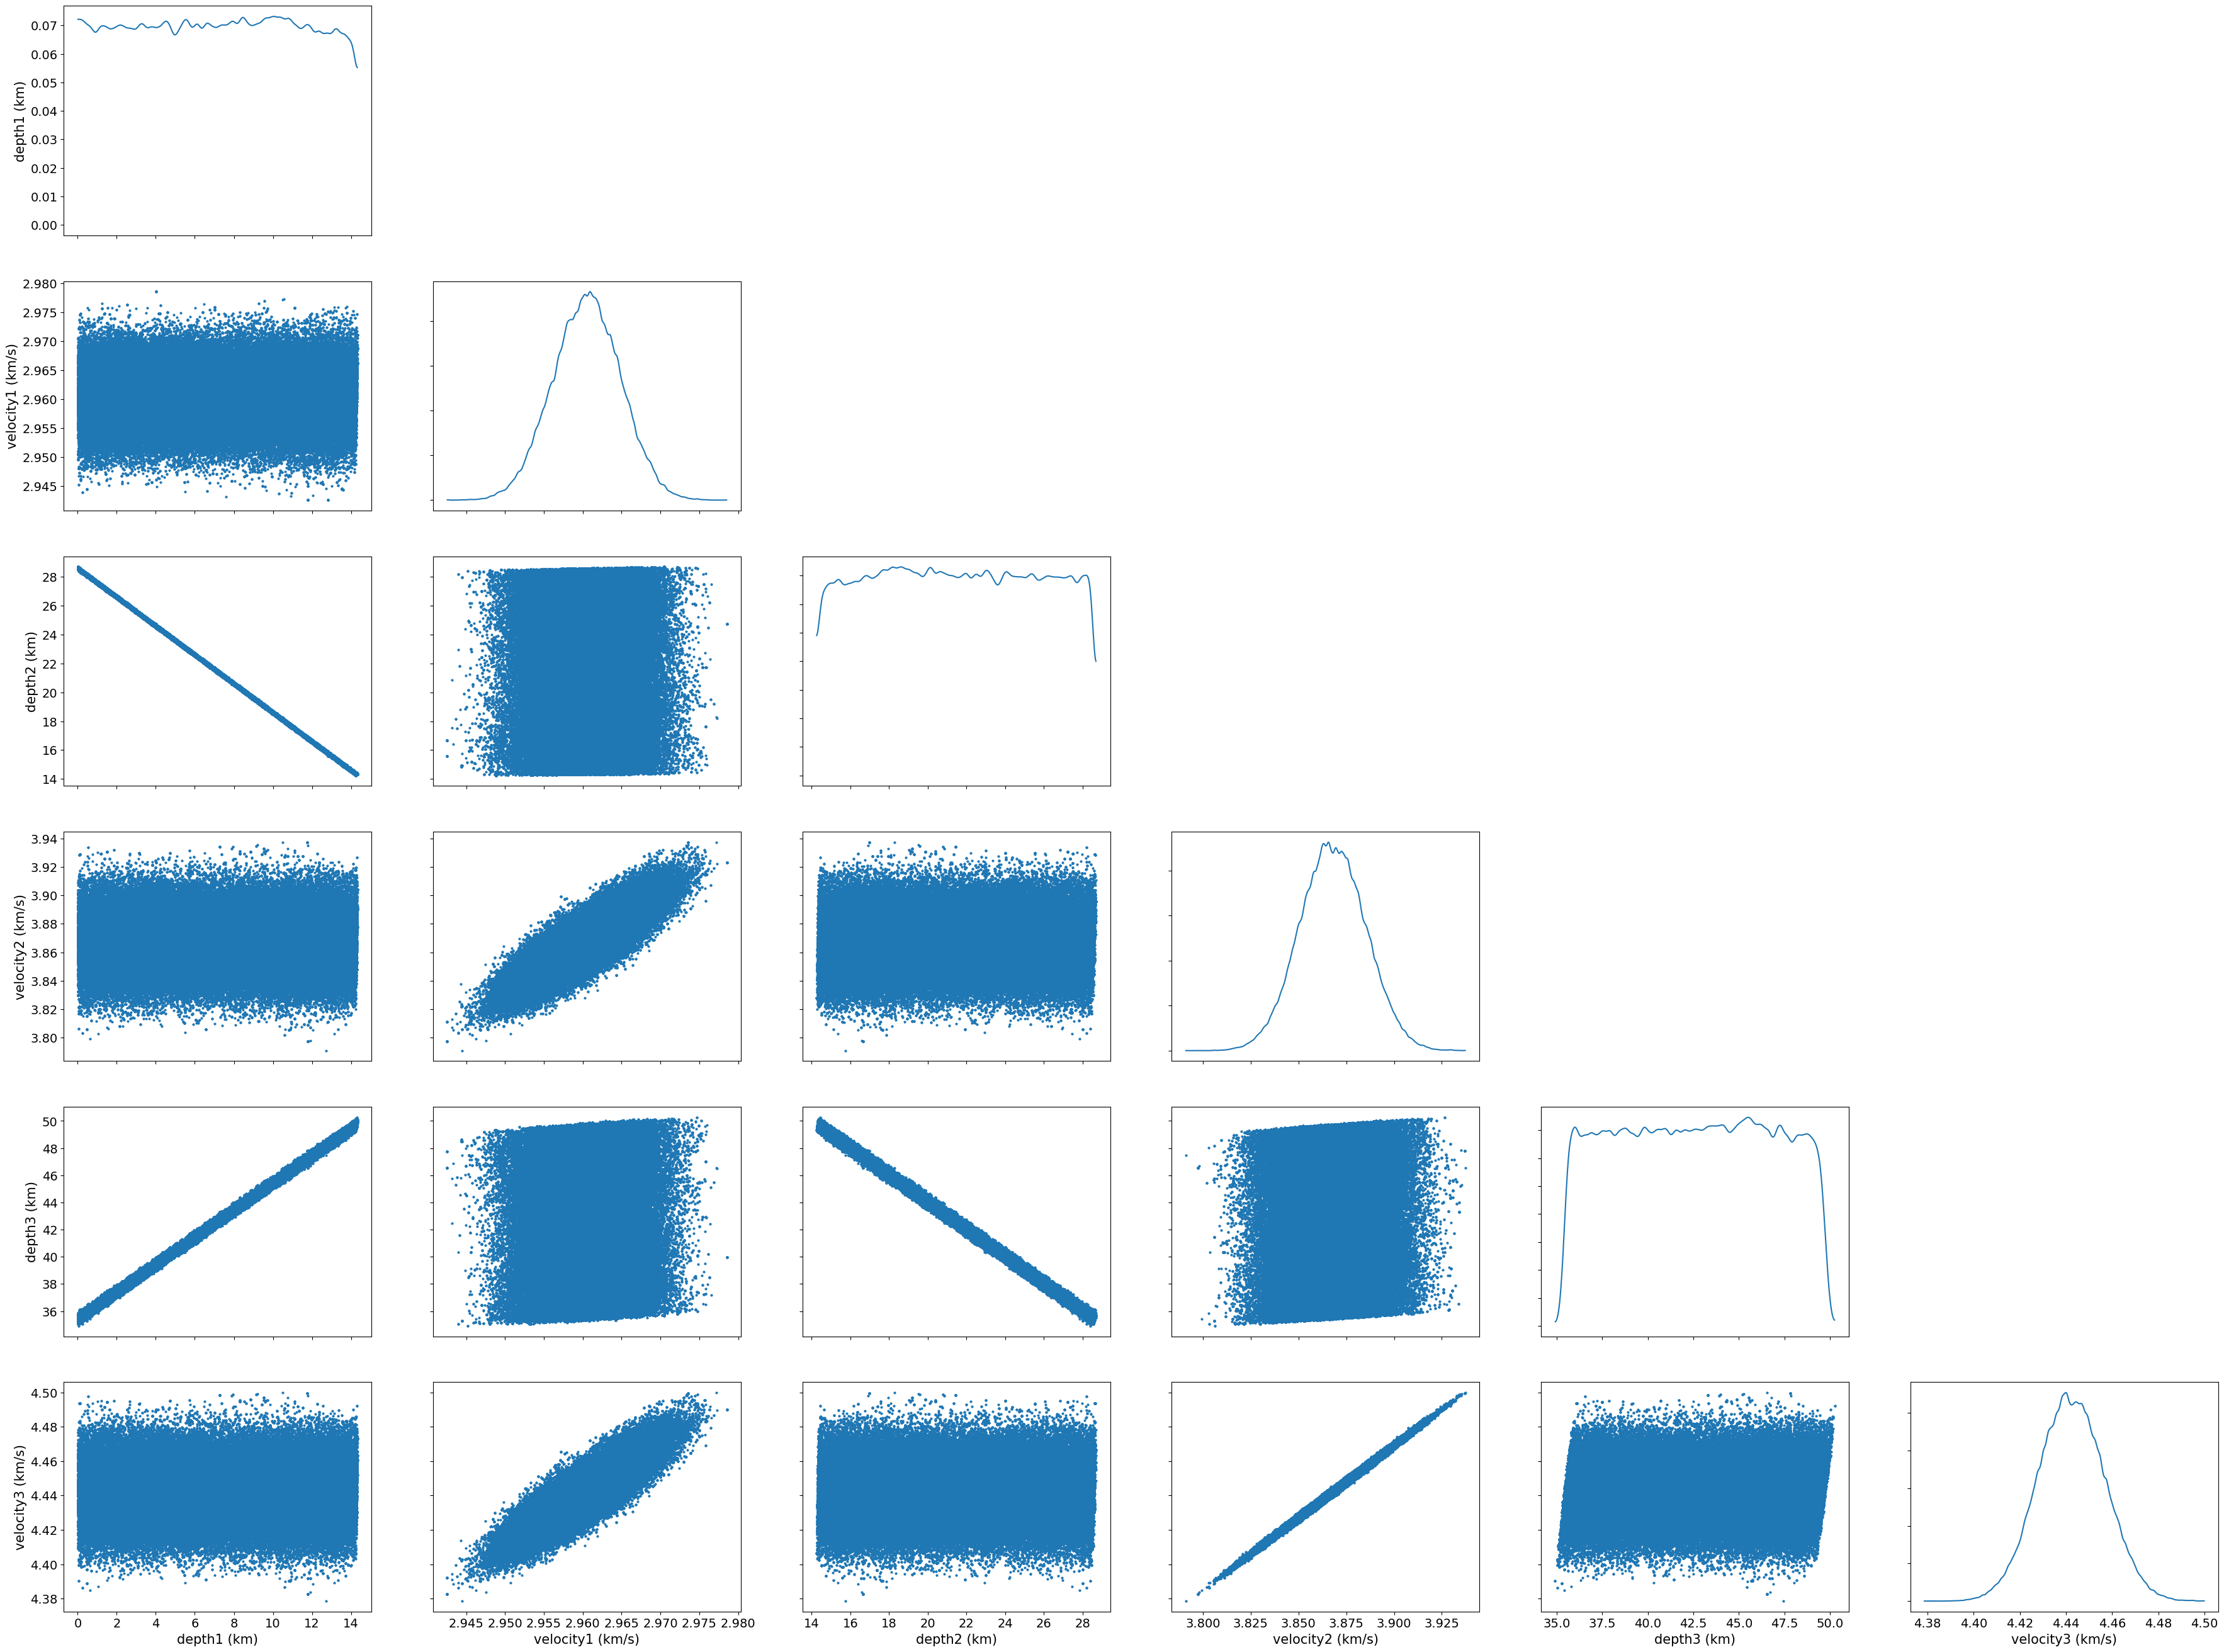

In [106]:
az_inf_data_after_300 = az_inf_data.sel(draw=slice(300,None))

arviz.plot_pair(
    az_inf_data_after_300, 
    marginals=True, 
    var_names=var_names
)

print("Reference good model:", my_receiver_function.good_model)

Mean of samples:      [ 7.18731319  2.96043176 21.41486067  3.8678814  42.62343852  4.4421232 ]
Reference good model: [ 8.   3.  20.   3.9 45.   4.4]


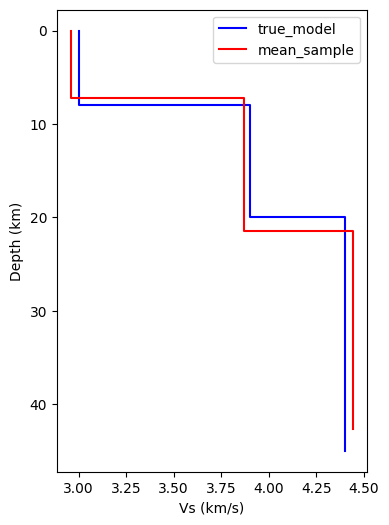

In [107]:
true_model = my_receiver_function.good_model
mean_sample = np.array(az_inf_data["posterior"][var_names].mean().to_array())
median_sample = np.array(az_inf_data["posterior"][var_names].median().to_array())

print("Mean of samples:     ", mean_sample)
print("Reference good model:", true_model)

my_receiver_function.plot_model(true_model, mean_sample, "true_model", "mean_sample")
plt.legend();

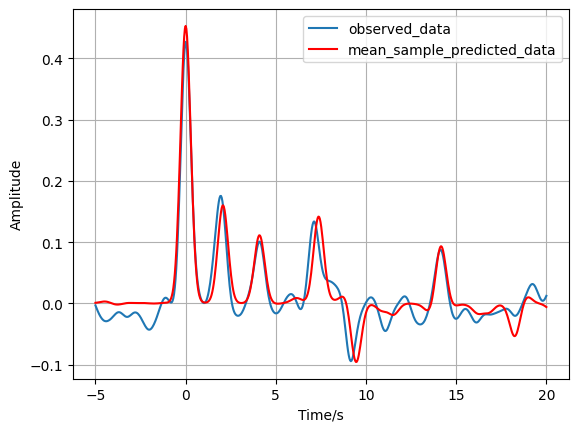

In [108]:
mean_sample_predicted_data = my_receiver_function.forward(mean_sample)
my_receiver_function.plot_data(
    observed_data, 
    mean_sample_predicted_data,
    "observed_data",
    "mean_sample_predicted_data",
);
plt.legend();

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [109]:
watermark_list = ["cofi", "espresso", "numpy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.10
espresso 0.3.19+63.g24043ca
numpy 2.1.3
matplotlib 3.10.1
emcee 3.1.6
arviz 0.20.0
